<a href="https://colab.research.google.com/github/GZabalaG/AIMaster/blob/main/Supervised/Actividad_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Cargar una de las imágenes histológicas

<function matplotlib.pyplot.show>

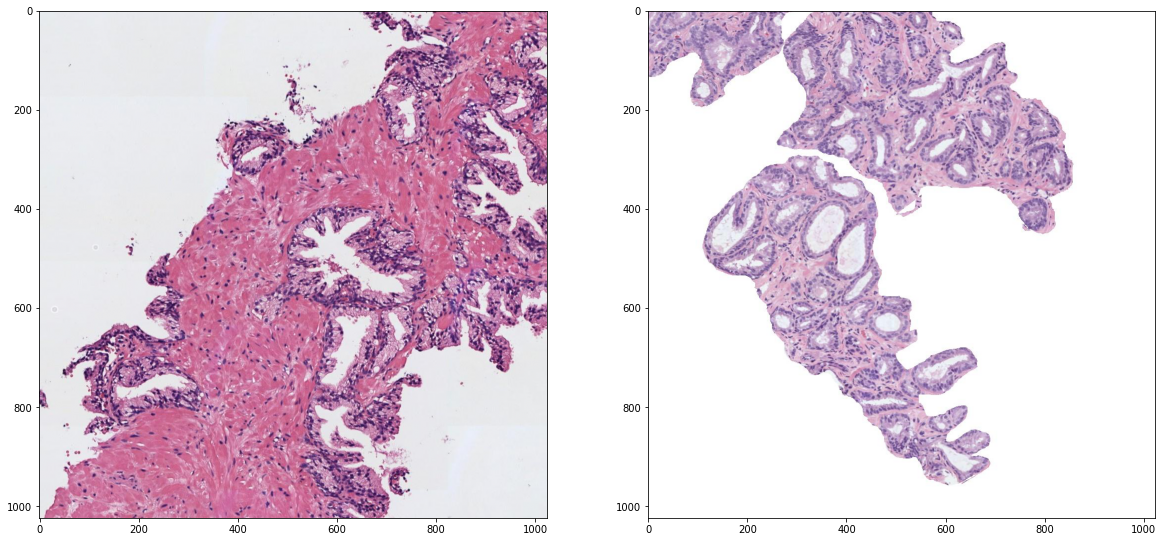

In [13]:
# Utiliza la librería skimage.io para leer la imagen 'histo_x.jpg' y visualízala usando la librería de matplotlib.
# Recuerda normalizar la imagen diviéndola entre 255
from skimage import io
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20, 10))


histo_1_pre = io.imread('/content/drive/MyDrive/Master IA/Aprendizaje Supervisado/histo_1.jpeg')
histo_2_pre = io.imread('/content/drive/MyDrive/Master IA/Aprendizaje Supervisado/histo_2.jpeg')

histo_1 = histo_1_pre / 255
histo_2 = histo_2_pre / 255

ax[0].imshow(histo_1, cmap='gray')
ax[1].imshow(histo_2, cmap='gray')
plt.show

#### Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [ ]:
# 1) Extrae la componente magenta de la imagen (que corresponde a la región tisular)
# 2) Visualiza la imagen con la librería de matplotlib. 
# 3) Guarda la imagen Magenta con cv2.imwrite con el nombre "1_imagen_magenta.png"


#### Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [ ]:
# 1) Convierte la imagen Magenta a formato "uint8"
# 2) Aplica un filtro gaussiano de tamaño 5x5
# 3) Umbraliza la imagen aplicando el método de Otsu
# 4) Aplica el umbral de manera que los píxeles del fondo y de los lúmenes sean 1s y el resto 0s. 
# 5) Visualiza la máscara resultante (imagen de 0s y 1s)
# 6) Guarda la máscara multiplicándola por 255 con el nombre "2_mascara_con_artefactos.png"


#### Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [ ]:
# 1) Utiliza la librería skimage.morphology.remove_small_objects. 
# Lee la documentación en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Fija el umbral en 300 píxeles y la conectividad del objeto en 8 píxeles.
# 2) Convierte la máscara generada en formato uint8
# 3) Visualiza la máscara resultante
# 4) Guarda la máscara multiplicándola por 255 con el nombre "3_mascara_sin_artefactos.png"


#### Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [ ]:
# 1) Aplica el algoritmo de expansión a partir de semillas para rellenar con 0s
# Pon dos semillas: una en la esquina superior izquierda y otra en la esquina inferior derecha.
# 2) Visualiza la máscara resultante
# 3) Guarda la máscara multiplicándola por 255 con el nombre "4_mascara_lumenes.png"


#### Rellenar los objetos de los lúmenes

In [ ]:
# 1) Rellena los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# 2) Convierte la máscara resultante en formato uint8
# 3) Visualiza la máscara
# 4) Guarda la máscara multiplicándola por 255 con el nombre "5_mascara_final.png"


#### Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [ ]:
# 1) Encuentra los contornos de los lúmenes
# 2) Dibuja los contornos (de color verde) sobre la imagen original
# 3) Visualiza la imagen superpuesta
# 4) Guarda la imagen multiplicándola por 255 con el nombre "6_imagen_superpuesta.png"


#### Identificar y cropear el lumen más grande

In [ ]:
# 1) Convierte la máscara de lúmenes en una imagen de etiquetas utilizando la librería skimage.measure
# 2) Calcula el área de cada uno de los lúmenes 
# 3) Obtén una máscara del lumen de mayor área
# 4) Haz un crop (recorte) del lumen de mayor área utilizando las coordenadas de la bounding box
# 5) Visualiza la máscara recortada del lumen
# 6) Guarda la imagen multiplicándola por 255 con el nombre "7_crop_image.png"


#### Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [ ]:
# Calcula las siguientes características del crop del lumen anterior, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Longitud del eje mayor
# 8) Longitud del eje menor
# 9) Orientación
# 10) Perímetro
# 11) Solidez
# 12) Compacidad
# 13) Rectangularidad
